In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader

In [2]:
#Seeing total number of images in each case
import seaborn as sns
cases=np.arange(1,100,1)
cases=[('case'+str(item)) for item in cases]


In [5]:
import os
sun_data=pd.read_csv('../input/sun-cases-all/all_sun_cases.csv')
sun_data.head()

,Case,Size
0,1,6mm
1,2,18mm
2,3,3mm
3,4,4mm
4,5,3mm


In [6]:
#Less than or equal to 
root_dir='../input/bounding-boxes-sun/Bounding Boxes/'
less_5=[]
less_10=[]
less_18=[]
for idx in range(sun_data.shape[0]):
    item=sun_data['Size'][idx] 
    item=item[:-2]
    item=int(item)
    if item<=5:
        less_5.append(root_dir+'case'+str(sun_data['Case'][idx]))
    elif item <= 10:
        less_10.append(root_dir+'case'+str(sun_data['Case'][idx]))
    else:
        less_18.append(root_dir+'case'+str(sun_data['Case'][idx]))
print('Cases in :\nLess 5mm : {}\nLess 10mm : {}\nLess 18mm : {}'.format(len(less_5),len(less_10),len(less_18)))

Cases in :
Less 5mm : 60
Less 10mm : 24
Less 18mm : 16


In [7]:
#Images per case
less_5_images=0
less_10_images=0
less_18_images=0
for idx in range(len(less_5)):
        try:
                images=os.listdir(less_5[idx])
                less_5_images+=(len(images))
        except: 
                continue
             
for idx in range(len(less_10)):
        try:
                images=os.listdir(less_10[idx])
                less_10_images+=(len(images))
        except:
                continue
for idx in range(len(less_18)):
        try: 
                images=os.listdir(less_18[idx])
                less_18_images+=(len(images))
        except:
                continue
             

In [8]:
print('Less than 5 mm images: {}\nLess than 10mm images: {}\nLess than 18mm images: {}'.format(less_5_images,less_10_images,less_18_images))

Less than 5 mm images: 23483
Less than 10mm images: 13133
Less than 18mm images: 11633


In [9]:
#2D CNN:
import torch.nn as nn
class Net_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.batchnorm1=nn.BatchNorm2d(16)
        self.maxpool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.linear1=nn.Linear(28*28*64,128)
        self.linear2=nn.Linear(128,256)
        self.linear3=nn.Linear(256,3)
        
    def forward(self,x):
        out=self.conv1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv3(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=out.view(-1,28*28*64)
        out=self.linear1(out)
        out=self.relu(out)
        #out=nn.Dropout(p=0.5)
        out=self.linear2(out)
       # out=nn.Dropout(p=0.5)
        out=self.linear3(out)
        return out


In [10]:
less_5=[item.split('/')[4] for item in less_5]
less_10=[item.split('/')[4] for item in less_10]
less_18=[item.split('/')[4] for item in less_18]

In [27]:
from tqdm import tqdm
#Assembling images into a dataframe:
#Directory for bounding boxes:
bbx_dir='../input/bounding-boxes-sun/Bounding Boxes/'
cases_bbx=os.listdir(bbx_dir)
cases_bbx=[os.path.join(bbx_dir,item) for item in cases_bbx]
columns=['Case','Image','Label']
polyp_data=pd.DataFrame(columns=columns)
for idx,item in tqdm(enumerate(cases_bbx)):
    
    case=cases_bbx[idx]
    case=case+'/'
    case_no=case.split('/')[4]
    if case_no in less_5:
        label=0
    elif case_no in less_10:
        label=1
    else:
        label=2
    images=os.listdir(case)
    images=[os.path.join(case,item) for item in images]
    for index in range(len(images)):
        temp_data=pd.DataFrame({
            'Case':[case_no],
            'Image': [images[index]],
            'Label':[label]
        })
        polyp_data=pd.concat([polyp_data,temp_data],ignore_index='True')

97it [01:37,  1.00s/it]


In [28]:
import cv2
#Creating a custom dataloader:
tensor_pth='../input/sundepth224/Tensors/'
from  torch.utils.data import Dataset
class polyp_dataset(Dataset):
    def __init__(self,images_df):
        self.image_paths=images_df
    def __len__(self):
        return self.image_paths.shape[0]
    def __getitem__(self,idx):
        img_path=self.image_paths['Image'][idx]
        img_name=img_path.split('/')[5]
        img_name=img_name.split('.')[0]
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(224,224))
        img=np.array(img,dtype='float32')
        case=self.image_paths['Case'][idx]
        tensor_cas=tensor_pth+case
        tensor_img=tensor_cas+'/'+img_name+'.pt'
        #print(tensor_img)
        #print(img.shape)
        tensor_img=torch.load(tensor_img)
        tensor_img=tensor_img.numpy()
        for row in range(tensor_img.shape[0]):
            for col in range(tensor_img.shape[1]):
                if img[row][col]==255:
                    img[row][col]= tensor_img[row][col]
       # plt.subplot(1,2,1)
        #plt.imshow(tensor_img,cmap='gray')
        tensor_img=img
        #plt.subplot(1,2,2)
        #plt.imshow(tensor_img,cmap='gray')
        tensor_img=tensor_img/255.0
        tensor_img=np.expand_dims(tensor_img,axis=0)
        tensor_img=torch.Tensor(tensor_img)
        label=self.image_paths['Label'][idx]
        return tensor_img,label

In [13]:
params={
    "device":'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size":128,
    "epochs":10,
    "lr":0.001
}

In [14]:
#Creating train test and valid datasets
from sklearn.model_selection import train_test_split
Polyp_Train,Polyp_Valid=train_test_split(polyp_data,random_state=42,shuffle=True,test_size=0.2)
Polyp_Valid,Polyp_Test=train_test_split(Polyp_Valid,random_state=42,shuffle=True,test_size=0.5)

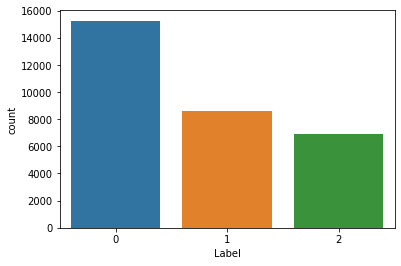

In [15]:
import seaborn as sns
sns.countplot(data=Polyp_Train,x=Polyp_Train['Label'])
plt.show()

In [16]:
print('Length of Training Data: {}\nLength of Testing Data: {}\nLength of Validation Data: {}'.format(Polyp_Train.shape[0],Polyp_Test.shape[0],Polyp_Valid.shape[0]))

Length of Training Data: 30739
Length of Testing Data: 3843
Length of Validation Data: 3842


In [17]:
#Reseting indices
Polyp_Train=Polyp_Train.reset_index()
Polyp_Train=Polyp_Train.drop(columns='index',axis=1)
#Polyp_Train=Polyp_Train.drop(columns='level_0',axis=1)
Polyp_Train.head()

,Case,Image,Label
0,case31,../input/bounding-boxes-sun/Bounding Boxes/cas...,2
1,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case27,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
3,case72,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
4,case68,../input/bounding-boxes-sun/Bounding Boxes/cas...,2


In [18]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test=Polyp_Test.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Test.head()

,Case,Image,Label
0,case32,../input/bounding-boxes-sun/Bounding Boxes/cas...,2
1,case44,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case16,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
3,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
4,case66,../input/bounding-boxes-sun/Bounding Boxes/cas...,1


In [19]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test=Polyp_Test.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Test.head()

,Case,Image,Label
0,case32,../input/bounding-boxes-sun/Bounding Boxes/cas...,2
1,case44,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case16,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
3,case20,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
4,case66,../input/bounding-boxes-sun/Bounding Boxes/cas...,1


In [29]:
#Creating datasets
train_dataset=polyp_dataset(Polyp_Train)
test_dataset=polyp_dataset(Polyp_Test)
validation_dataset=polyp_dataset(Polyp_Valid)

In [30]:
#Creating dataloaders
from torch.utils.data import DataLoader
train_loader=DataLoader(dataset=train_dataset,num_workers=2,pin_memory=True,shuffle=True,batch_size=params['batch_size'])
test_loader=DataLoader(dataset=test_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])
val_loader=DataLoader(dataset=validation_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])

In [31]:
model=Net_2D()
model=model.cuda()
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [32]:
num_epochs=10
train_loss=[]
train_accuracy=[]
testing_loss=[]
test_accuracy=[]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3)
for epoch in range(num_epochs):
    correct=0
    iterations=0
    iter_loss=0.0
    print('Started training for {} epochs'.format(num_epochs))
    model.train()
    print('Epoch: {}'.format(epoch+1)) 
    for i,(inputs,labels) in enumerate(train_loader):
        
        batch_correct=0  
        inputs=inputs.cuda()
        labels=labels.cuda()
        output = model(inputs)
       
        loss= criterion(output,labels)
        
        iter_loss+=loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        _,predicted=torch.max(output,1)
        correct+=(predicted==labels).sum().item()
        batch_correct=(predicted==labels).sum().item()
        iterations+=1
        
        print('iterations_completed: {}, Loss: {}, Accuracy {} '.format(i,iter_loss/iterations,100*batch_correct/64),end="\r")
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100*correct/len(train_dataset))
    

Started training for 10 epochs
Epoch: 1
Started training for 10 epochss: 0.6981381363393855, Accuracy 21.875   
Epoch: 2


KeyboardInterrupt: 

In [33]:
preds=[]
targets=[]
for idx,data in tqdm(enumerate(test_loader)):
    image,label=data
    image=image.cuda()
    pred=model(image)
    _,pred=torch.max(pred,axis=1)
    preds.append(pred)
    targets.append(label)

31it [09:47, 18.95s/it]


In [34]:
new_preds=[]

for item in range(len(preds)):
    for idx in range(len(preds[item])):
        ele=preds[item][idx]
        new_preds.append(ele)

In [35]:
new_targets=[]


for item in range(len(targets)):
    for idx in range(len(targets[item])):
        ele=targets[item][idx]
        new_targets.append(ele)

In [36]:
for idx in range(len(new_targets)):
    new_targets[idx]=new_targets[idx].cpu()
    new_preds[idx]=new_preds[idx].cpu()

In [37]:
new_targets=np.array(new_targets)
new_preds=np.array(new_preds)
for idx in range(new_targets.shape[0]):
    new_targets[idx]=int(new_targets[idx])
    new_preds[idx]=int(new_preds[idx])

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(new_targets,new_preds)

In [39]:
cm

array([[1349,  494,   46],
       [ 315,  701,   73],
       [  84,  209,  572]])

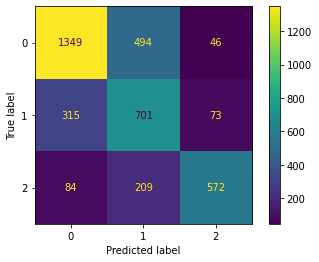

In [40]:
disp=ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

In [44]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [47]:
accuracy=accuracy_score(new_preds,new_targets)
accuracy

0.682279469164715

In [48]:
precision=precision_score(new_preds,new_targets,average='macro')
precision

0.6730386548357504

In [49]:
recall=recall_score(new_preds,new_targets,average='macro')
recall

0.6996042324593678

In [50]:
f1=f1_score(new_preds,new_targets,average='macro')
f1

0.6798044464943068